# Introduction

In this notebook, we analyse a sample of PBMCs. Here, we cover normalization, batch effect correction, selection of highly variable genes, computing cell cycle scores, conduct an initial clustering and visualisation of the data.

## Load packages

In [2]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb

#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri


In [3]:
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
fbpca               NA
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
intervaltree        NA
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server  

Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all seaborn plots, but switch to smaller legends here to avoid overlap of the plot and the legend. You can set the context as well to 'poster' or 'paper'.

In [4]:
sb.set_context(context='talk')


In [5]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(DropletUtils)


# Set project file paths

We set up the file paths to the respective directories.

In [6]:
file_path = '/root/host_home/Documents/ICB/Teaching/2103_scanpy_HMGU_presenter/' 
#this is my file path please adapt it to your directory

File path to the raw data. They are usually stored at a different location than the rest of the project.

In [7]:
file_path_raw = file_path + '3k_PBMC/'

The data directory contains all processed data and `anndata` files. 

In [8]:
data_dir = file_path + 'PBMC_docker/data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [9]:
table_dir = file_path + 'PBMC_docker/tables/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [10]:
sc.settings.figdir = file_path + 'PBMC_docker/figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a date variable and add it to every figure and table (see `datetime` Python package).

In [12]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Read data

The post-QC dataset, which consists of 3k PBMCs (Human) provided by 10X Genomics.

In [13]:
adata = sc.read(data_dir + 'data_postQC.h5ad')

# Normalization and Batch effect correction

## Normalization

So far, our dataset is a count matrix. Here, every count corresponds to an mRNA molecule captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Several methods for normalization for scRNA-seq data have been proposed. Here, we the `scran` library size normalization followed by log-transformation. In addition, we save the count matrix to `layers` as 'counts'.

**Comment:** We have (not comprehensively) tested whether normalisation per sample or all samples jointly gives more accurate results. When we normalised per sample, observed many more differentially expressed genes across conditions (in the range of thousands). We think that normalisation per sample preserves a systematic bias while joint normalisation removes batch effects within the same cluster partially, if a cluster contains cell from several batches. No such effect of the normalisation can be observed when samples do not overlap at all. For the time being, we perform joint normalisation of all samples. 

In [14]:
adata.layers['counts'] = adata.X.copy()

In [15]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [16]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [17]:
%%R -i data_mat -i input_groups -o size_factors
#need to wrap the "computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)" call due to version change in Bioconductor 3.11,
#see issue discussion in: https://github.com/theislab/scib/issues/141
size_factors = BiocGenerics::sizeFactors(
                      scran::computeSumFactors(
                            SingleCellExperiment::SingleCellExperiment(list(
                                  counts=data_mat
                            ))
                          )
                        )


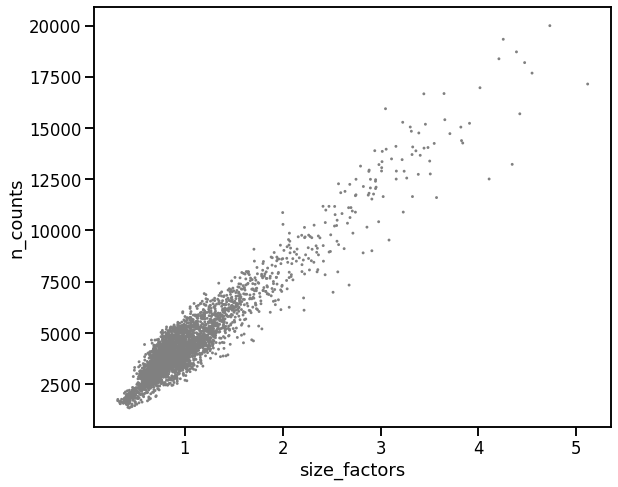

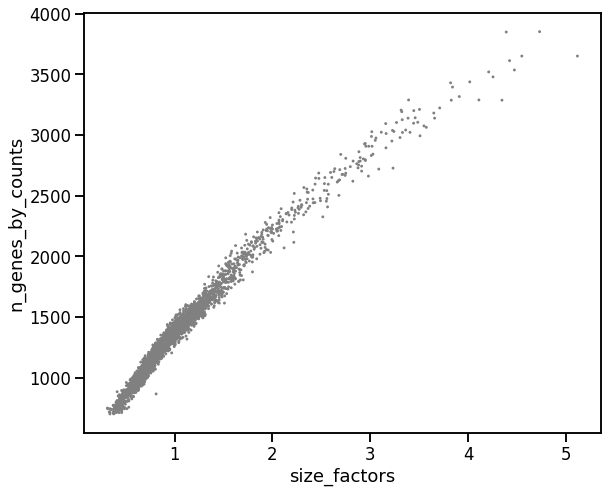

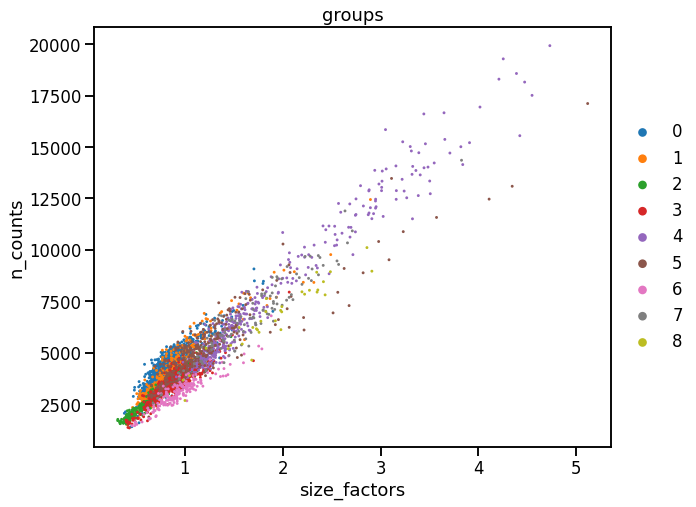

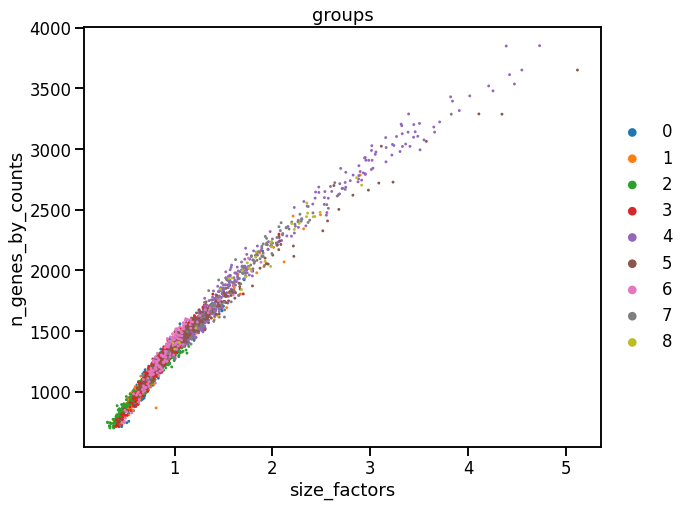

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


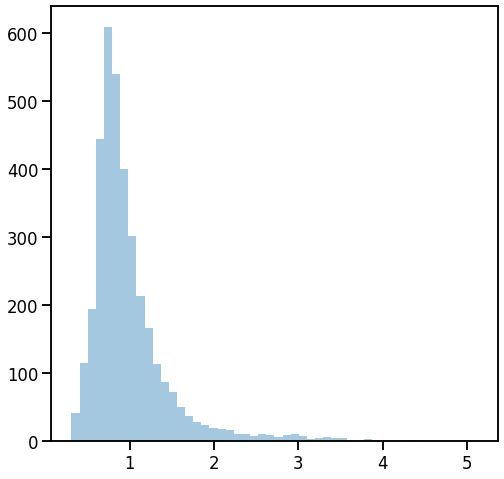

In [18]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes_by_counts')

sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes_by_counts', color='groups')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

Normalize with scran size-factors and log-scale. 

In [19]:
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

Modify the format of the resulting data matrix.

In [20]:
adata.X = np.asarray(adata.X)

Free memory.

In [21]:
del adata_pp

Of note, we convert the gene expression matrix X to the sparse format to memory.

In [22]:
import scipy.sparse as sparse

In [23]:
adata.X = sparse.csr_matrix(adata.X)

## Batch correction - general remarks

This dataset consists of a single batch, thus, batch effect correction is not an issue here. If you handle several batches, you may observe differences across samples, for instance, in the library size per dataset. Such differences may contribute to the batch effect. [Büttner et al., Nat Meth (2019)](https://www.nature.com/articles/s41592-018-0254-1) compared the performance of several batch correction methods. For low-to-medium complexity datasets, ComBat performed best among the tested tools. ComBat is also available in `scanpy` (see `sc.pp.combat`). 

For high complexity data, especially when you encounter changes in cell type composition, consider to use a data integration method of your choice. We distinguish three different types, *i.e.* if the methods create a corrected data matrix (in feature space), an embedding or a knn-graph. Examples are:
1. feature space: MNN (`scanpy.external.pp.mnn_correct`), scanorama (integrates with scanpy), Seurat v3 (R based)
2. embedding: scVI (Python based), Harmony (R based), scanorama
3. knn-graph: conos (R based), BBKNN (`scanpy.external.pp.bbknn`)

Several benchmarking studies aimed to determine best performing methods. In simple cases, Seurat v3 and Harmony performed best [Tran et al., Genome Biology (2020)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9) and [Chazarra-Gil et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111211v2). More complex scenarios have been benchmarked in [Luecken et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2), where BBKNN, Scanorama, and scVI performed well. Furthermore, Scanorama had high scores in the preservation of biological signals, while BBKNN tended to overcorrect. Moreover, Luecken et al. tested different pre-processing schemes. In general, **selecting highly variable genes prior to batch correction improved the batch effect correction result**. We continue with the selection of highly variable genes. 


## Feature selection (Highly variable genes)

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X Genomics preprocessing software *CellRanger*. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

Compute highly variable genes and visualize.

In [24]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


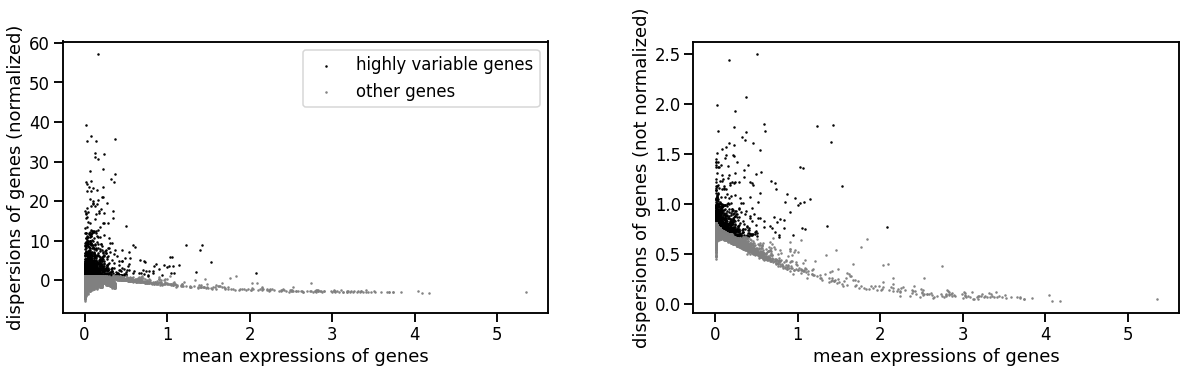

In [25]:
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the `adata.var['highly_variable']` field. The dataset now contains:

* count data as layer 'counts' in adata
* log-scran normalized data in adata.X
* highly variable gene annotations in `adata.var['highly_variable']`


## Cell cycle scoring

Known sources of technical variation in the data have been investigated and corrected for (e.g. batch, count depth). A known source of biological variation that can explain the data is the cell cycle. Here, gene lists from [Macosko et al., Cell 161 (2015)](https://www.sciencedirect.com/science/article/pii/S0092867415005498) is used to score the cell cycle effect in the data and classify cells by cell cycle phase. The file can be found on the [scIB github repository](https://github.com/theislab/scib/tree/master/scIB/resources/).

Please note, that the gene list was generated for human HeLa cells.

In [26]:
s_genes_file = data_dir + 's_genes_tirosh_hm.txt'
g2m_genes_file = data_dir + 'g2m_genes_tirosh_hm.txt'

In [27]:
s_genes = pd.read_table(s_genes_file, header = None).values.flatten()
g2m_genes = pd.read_table(g2m_genes_file, header = None).values.flatten()

In [28]:
s_genes_hvg = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes_hvg = adata.var_names[np.in1d(adata.var_names, g2m_genes)]

Compute cell cycle score.

In [29]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_hvg, g2m_genes=g2m_genes_hvg)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    468 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    440 total control genes are used. (0:00:00)


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


-->     'phase', cell cycle phase (adata.obs)


In [30]:
print(len(s_genes_hvg))
print(len(g2m_genes_hvg))

27
26


In [31]:
adata.obs['phase'].value_counts()

G1     1413
G2M    1147
S      1058
Name: phase, dtype: int64

**COMMENT:** End of third session. 

# Visualization 

## low dimensional embeddings

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

We will look at several visualizations to decide which visualization best represents the aspect of the data.

Compute the following embeddings: PCA, t-SNE, UMAP, diffusion map and force-directed graph. Please compute PCA first and compute nearest neighbors next. All other embeddings rely on this information. Visualize the embeddings and color by the total number of counts.

In [32]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:00)


To determine the number of informative principal components, let us review the variance contribution of each component. 

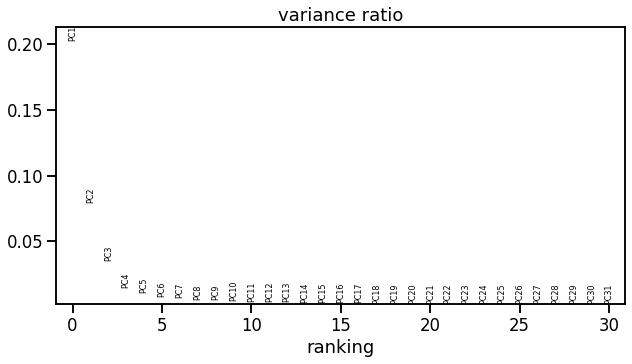

In [33]:
sc.pl.pca_variance_ratio(adata)

Using the elbow method, we select the first 6 PCs as informative. It must be noted that the elbow method is not a strict scientific criterion to select the correct number of PCs. For instance, the variance of the gene expression from rare cell types might only be covered by the latter PCs. Therefore, consider to try out different numbers of PCs and examine the differences in the resulting low-dimensional embeddings. 

In [34]:
sc.pp.pca(adata, n_comps=6, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.tsne(adata) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=6
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 6
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9999837  0.9998249  0.9989291  0.9972236  0.9961737
     0.995577   0.99420846 0.9852752  0.9819709  0.96666723 0.96415657
     0.96134114 0.9481611  0.9449726 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of tran

... storing 'phase' as categorical


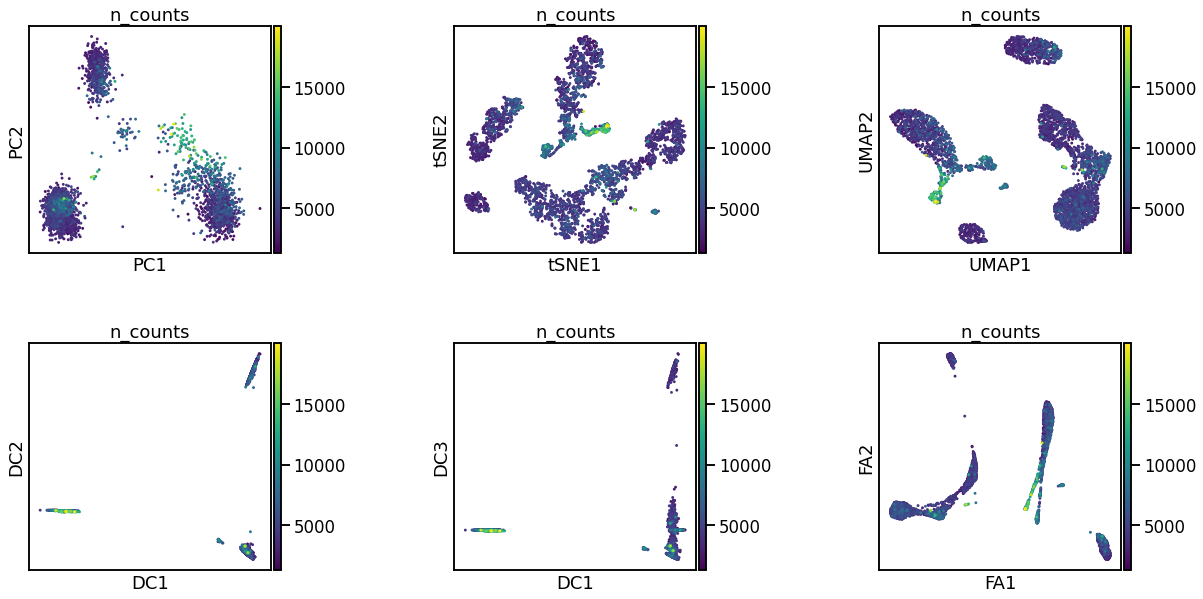

In [35]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
p13 = sc.pl.diffmap(adata, color='n_counts', components=['1,2'], ax=fig.add_subplot(fig_ind[3]),show=False)
p14 = sc.pl.diffmap(adata, color='n_counts', components=['1,3'], ax=fig.add_subplot(fig_ind[4]), show=False)
p15 = sc.pl.draw_graph(adata, color='n_counts', ax=fig.add_subplot(fig_ind[5]), show=False)

plt.show()

**PCA**:

* Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
* The plot shows a weak clustering of the data in two dimensions

**t-SNE**:

* Shows several distinct clusters with clear subcluster structure
* Connections between clusters are difficult to interpret visually

**UMAP**:

* Data points are spread out on the plot showing several clusters
* Connections between clusters also not visible (and not expected for PBMC data)

**Diffusion Maps**:

* Shows regions of higher density and a few disconnected cells in between
* Trajectories not visible (and not expected for PBMC data)
* Each diffusion component extracts heterogeneity in a different part of the data

**Graph**:

* Shows several clusters with substructure
* Lack of trajectories as expected

The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute. UMAP has furthermore been shown to more accurately display the structure in the data.

Next, let us compute an embedding density. We use the UMAP representation as basis.

In [36]:
sc.tl.embedding_density(adata, basis='umap')

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


/opt/python/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1156: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/opt/python/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1157: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_under('lightgray')
/opt/python/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will

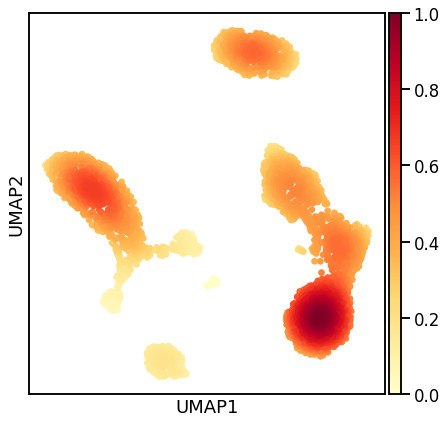

In [37]:
rcParams['figure.figsize']=(7,7)
sc.pl.embedding_density(adata, basis='umap')

## Visualise cell cycle score

Let us check whether MKI67 is present in the dataset.

In [38]:
sum(adata.var_names == 'MKI67')

1

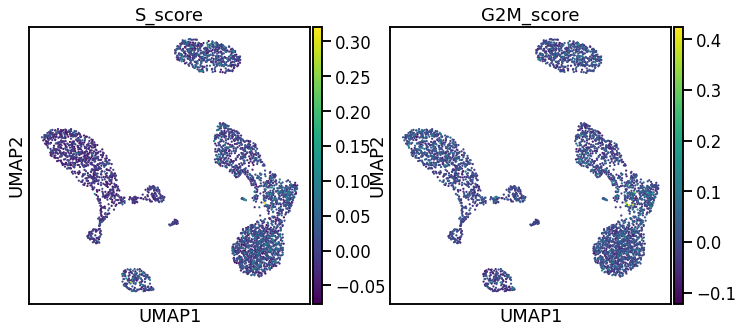

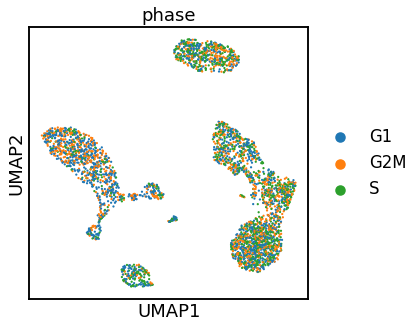

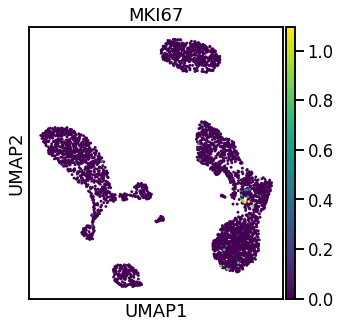

In [39]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['S_score', 'G2M_score'], size=20, use_raw=False)
sc.pl.umap(adata, color=['phase'], size=20, use_raw=False)
#a classical interphase marker is MKI67
sc.pl.umap(adata, color='MKI67')

Apparently, all cells are assigned to the same proliferative cell cycle phase (G2M), but inspecting the interface marker MKI67 shows little evidence for proliferation. If the phase score looks suspicious, one has to adjust the threshold for assigning a certain phase. By default, a cell is G1, if both S and G2M score are negative. Otherwise, a cell is assigned to the phase where it has the highest score. Potentially, we would need to adapt the cutoffs of the classification.

At this point of the analysis, we have reached an important milestone as we finished the pre-processing and enter the downstream analysis part. **Ideally, we don't have to revisit this part again.**

In [40]:
adata.write(data_dir + 'data_processed.h5ad')

## Visualise gene expression

In this session, we focus on the various plotting functions in `scanpy` to visualise gene expression patterns per cell and for groups of cells. On the one hand, using various ways of visualising data helps to find patterns and identify cell types. On the other hand, we aim to show how to prettify plots in `scanpy`. 

We will look at visualising gene expression:
* on low dimensional embedding plots
* as heatmap
* as tracksplot
* as matrixplot
* as (stacked) violin plot
* as dotplot


Please note that we leave the "stringent" data analysis workflow. When you start working with `scanpy` in your own analysis projects, you might single out a few plotting functions, which you find the most useful to quickly explore the data, and only reconsider other means to visualise data only upon finalising a project. 

In order to display groups of cells, we will use a clustering approach called "leiden clustering", which will be explained in detail on day 3.



Let us visualise gene expression on low dimensional embeddings. We use some marker genes for PBMCs (e.g. CD79A, CD3D, MS4A1, FCER1A).  

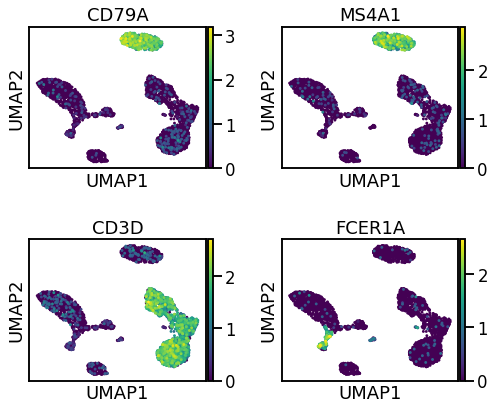

In [41]:
rcParams['figure.figsize'] = 3,3
sc.pl.umap(adata, color=['CD79A', 'MS4A1', 'CD3D', 'FCER1A'], 
           ncols=2, #number of columns to use 
           hspace=0.5, #space between 2 rows
           wspace=0.3, #space between 2 columns
          )

Let us prettify the plots: The maximum value plotted can be adjusted using `vmax` (similarly vmin can be used for the minimum value). In this case we use `p99`, which means to use as max value the 99 percentile (less biased by outliers). The max value can be a number or a list of numbers if the `vmax` wants to be set for multiple plots individually.

Also, we are using `frameon=False` to remove the boxes around the plots and `s=50` to set the dot size. Lastly, we change the color map to a Red scale.

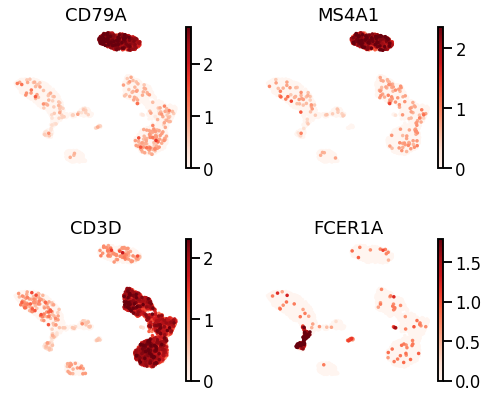

In [42]:
rcParams['figure.figsize'] = 3,3
sc.pl.umap(adata, color=['CD79A', 'MS4A1', 'CD3D', 'FCER1A'], 
           hspace=0.5, #space between 2 rows
           wspace=0.3, #space between 2 columns
           s=50, #dot size
           frameon=False, ncols=2, vmax='p99',
           color_map='Reds'
          )

Let us scale the data and save it as `layer`.

In [43]:
# scale and store results in layer
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Compute low resolution clustering.

In [44]:
sc.tl.leiden(adata, key_added='clusters', resolution=0.5)

running Leiden clustering
    finished: found 10 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


Visualise clustering. The functions for scatterplots have many options that allow fine tuning of the images. For example, we can look at the clustering as follows:

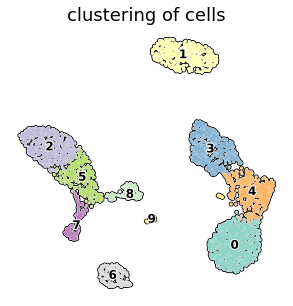

In [45]:
rcParams['figure.figsize'] = 5, 5
sc.pl.umap(adata, color='clusters', #plot categorical values
           add_outline=True, #black outline on all cells
           legend_loc='on data', #plot cluster ID on data
           legend_fontsize=12, 
           legend_fontoutline=2,
           frameon=False,
           title='clustering of cells', 
           palette='Set3' #use a colorbrewer scheme for categorical data
          )

The full set of options can be found in the documentation of the plotting functions.

Create a violin plot with and without internal dots.

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/

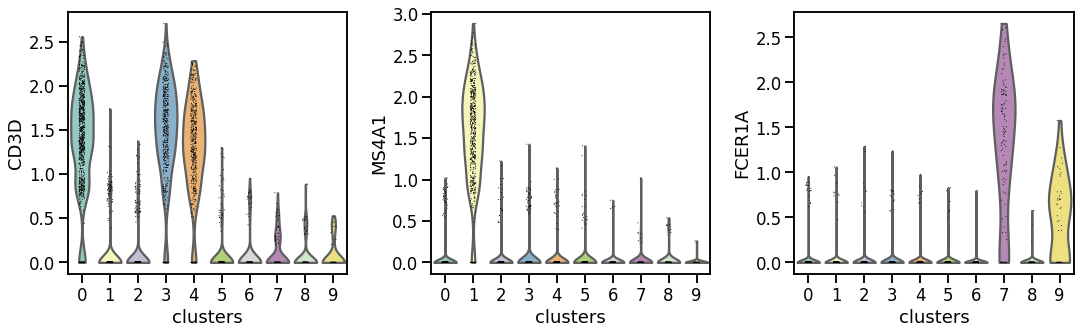

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


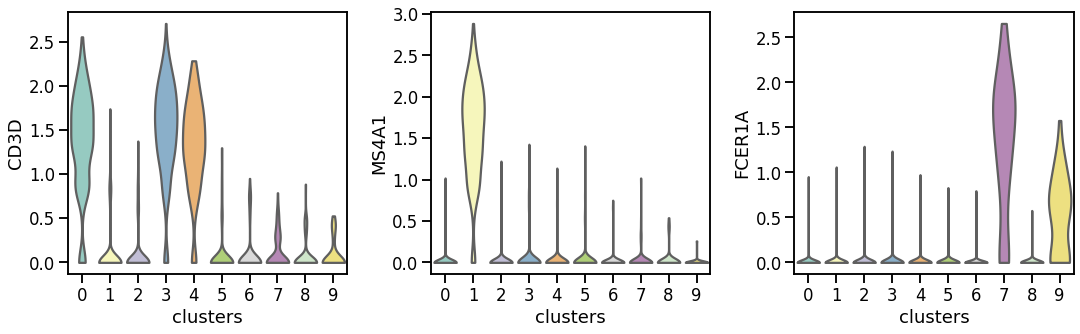

In [46]:
sc.pl.violin(adata, keys=['CD3D', 'MS4A1', 'FCER1A'],
              groupby='clusters', 
              dendrogram=True, figsize=(5,4))
sc.pl.violin(adata, keys=['CD3D', 'MS4A1', 'FCER1A'],
              groupby='clusters',  stripplot=False,
              dendrogram=True, figsize=(5,4))

Create a heatmap.

    using 'X_pca' with n_pcs = 6
Storing dendrogram info using `.uns['dendrogram_clusters']`


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


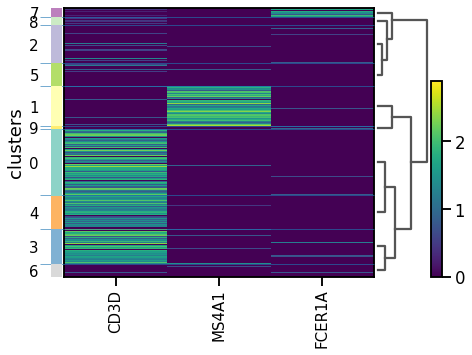

In [47]:
sc.pl.heatmap(adata, var_names=['CD3D', 'MS4A1', 'FCER1A'], 
              figsize=(7,5), #set figure shape
              groupby='clusters', cmap='viridis', dendrogram=True)

Use the `swap_axes=True` command to create a horizontal heatmap.

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


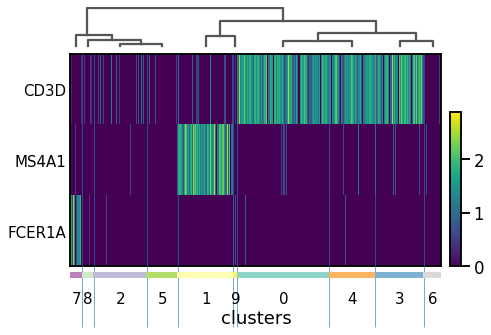

In [49]:
sc.pl.heatmap(adata, var_names=['CD3D', 'MS4A1', 'FCER1A'], 
              groupby='clusters', 
              cmap='viridis', #color map
              dendrogram=True, swap_axes=True, figsize=(7,5))

Show the scaled version of the data and use a diverging color map.

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


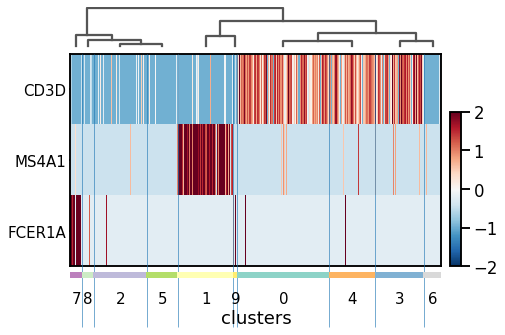

In [50]:
sc.pl.heatmap(adata, var_names=['CD3D', 'MS4A1', 'FCER1A'], layer='scaled',
              groupby='clusters', 
              vmin=-2, vmax=2, #fix minimum and maximum
              cmap='RdBu_r',  #color map
              dendrogram=True, swap_axes=True, figsize=(7,5))

Use a tracksplot instead of a heatmap.

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


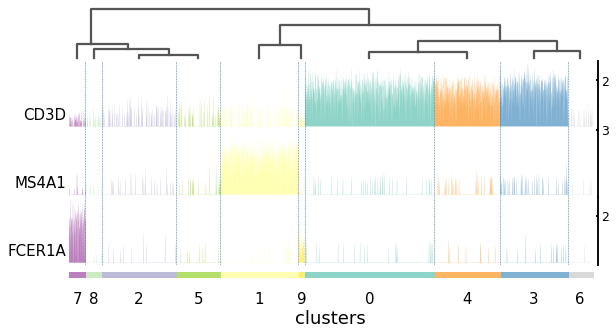

In [51]:
sc.pl.tracksplot(adata, var_names=['CD3D', 'MS4A1', 'FCER1A'],
              groupby='clusters', 
              dendrogram=True, swap_axes=True, figsize=(10,5))

Create a dotplot, a matrixplot and a stacked violin plot by replacing the corresponding keyword. 

    using 'X_pca' with n_pcs = 6
Storing dendrogram info using `.uns["dendrogram_['clusters']"]`


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


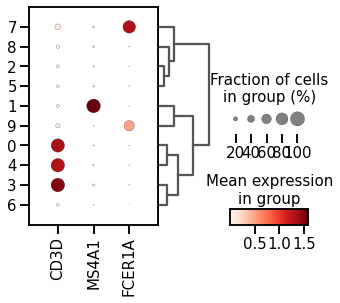

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


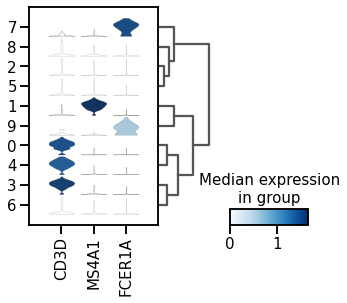

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


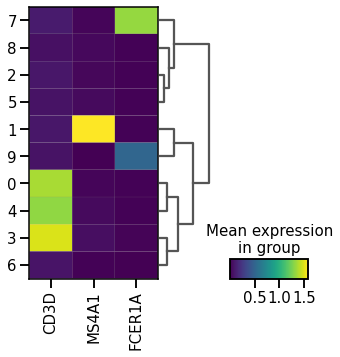

In [52]:
sc.pl.dotplot(adata, var_names=['CD3D', 'MS4A1', 'FCER1A'],
              groupby='clusters', 
              dendrogram=True, figsize=(5,4))

sc.pl.stacked_violin(adata, var_names=['CD3D', 'MS4A1', 'FCER1A'],
              groupby='clusters', 
              dendrogram=True, figsize=(5,4))

sc.pl.matrixplot(adata, var_names=['CD3D', 'MS4A1', 'FCER1A'],
              groupby='clusters', 
              dendrogram=True, figsize=(5,5))

Advanced plotting: Add cluster size as barchart to the top of the plot.

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


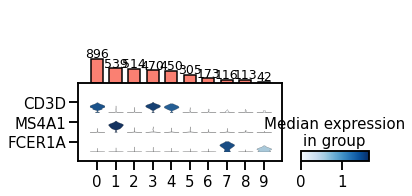

In [53]:
vp = sc.pl.stacked_violin(adata,var_names=['CD3D', 'MS4A1', 'FCER1A'], swap_axes=True,
              groupby='clusters', return_fig=True)
vp.add_totals().style(ylim=(0,5)).show()

More inspiration can be found in the [scanpy plotting tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html) and the [scanpy plotting documentation](https://scanpy.readthedocs.io/en/stable/api/scanpy.plotting.html). 

**Tasks:** Choose one of the plots and customize it to your liking. 

Examples:
* Take your favourite embedding and display all genes of interest on the same color scale (0-1). 
* Choose your own color scale, please get inspired from the [list of colors](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
* Plot only two of the clusters.
* Remove the dendrogram.
* Change the figure size and shape.


Here's a list of marker genes from literature for the subpopulations of PBMCs.

In [54]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

**COMMENT:** End of fourth session and day 2.

Save data to file.

In [55]:
adata.write(data_dir + 'data_processed-vis.h5ad')